<a href="https://colab.research.google.com/github/tmbharathiraja/pytorch/blob/main/notebooks/01_01_Classification_CIFAR10_FlightVsBird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, __version__ as tv_version
import numpy as np
import os
import datetime

import matplotlib.pyplot as plt

print(t.__version__)
print(tv_version)
print(np.__version__)

2.8.0+cu126
0.23.0+cu126
2.0.2


# Gdrive

In [22]:
try:
    import google.colab as colab
    IS_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IS_COLAB = False
    print("Not running in Google Colab")


if IS_COLAB:
    colab.drive.mount("/content/gdrive")
    os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Pytorch-DeepLearningBook/dlwpt-code-master/data/dummy')
    os.getcwd()

Running in Google Colab
Mounted at /content/gdrive


# Data

In [23]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [24]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [25]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [26]:
print(f"{len(cifar2) = }, {len(cifar2_val) =}")

len(cifar2) = 10000, len(cifar2_val) =2000


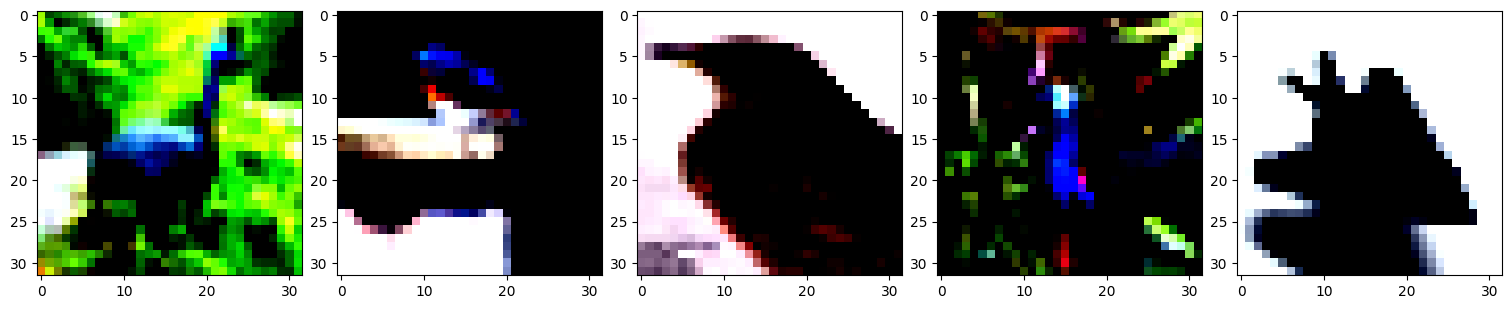

In [27]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
for ax, (img, label) in zip(axes, cifar2[:10]):
  ax.imshow(img.permute(1, 2, 0))
plt.show()

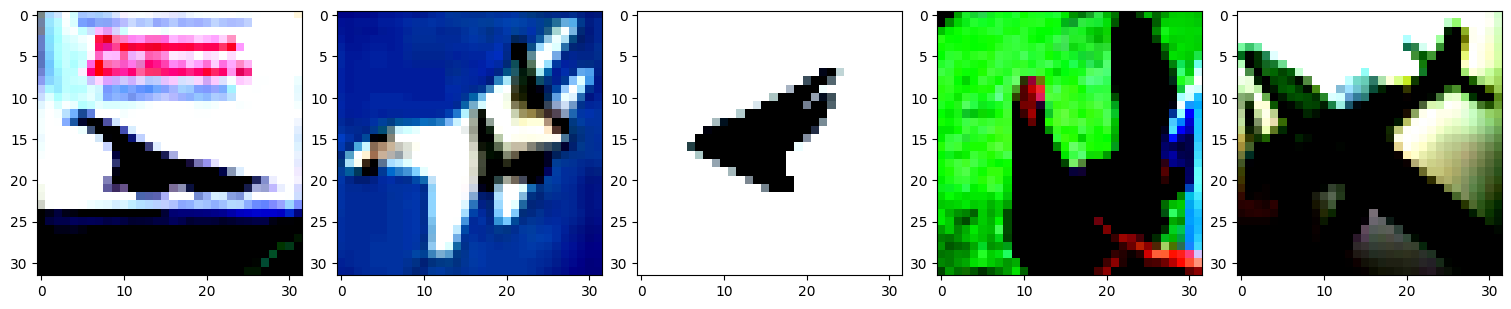

In [28]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
for ax, (img, label) in zip(axes, cifar2_val[:10]):
  ax.imshow(img.permute(1, 2, 0))
plt.show()

# CNN

In [29]:
class ResBlock(nn.Module):
  def __init__(self, n_chans=16):
    super(ResBlock, self).__init__()
    self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
    self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
    nn.init.kaiming_normal_(self.conv.weight, nonlinearity = 'relu')
    nn.init.constant_( self.batch_norm.weight, 0.5)
    nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = t.relu(out)
    return out + x

In [30]:
(10 * [ResBlock()])

[ResBlock(
   (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 ResBlock(
   (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 ResBlock(
   (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 ResBlock(
   (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 ResBlock(
   (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [33]:
class NetResDeep(nn.Module):
  def __init__(self, n_chans1=32, n_blocks=10):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, self.n_chans1, kernel_size = 3, padding = 1, bias = False)
    self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(self.n_chans1)]))
    self.fc1 = nn.Linear(8*8*self.n_chans1, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(t.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 8*8*self.n_chans1)
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out



In [34]:
model = NetResDeep()
optim = t.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [43]:
def training(n_epochs, model, optim, loss_fn, train_loader):
  for epoch in range(1, n_epochs+1):
    loss_train = 0.0

    for imgs, labels in train_loader:
      y_pred = model(imgs)
      loss = loss_fn(y_pred, labels)

      optim.zero_grad()
      loss.backward()
      optim.step()

      loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
        print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

In [44]:
train_loader = t.utils.data.DataLoader(cifar2, batch_size=64, shuffle = True)

training(100, model, optim, loss_fn, train_loader)

2025-10-31 02:31:14.131293 Epoch 1, Training loss 0.32427597330634
2025-10-31 02:38:10.076970 Epoch 10, Training loss 0.21764119012150795
2025-10-31 02:45:43.709544 Epoch 20, Training loss 0.13071371681371313
2025-10-31 02:53:14.482054 Epoch 30, Training loss 0.0812493957591
2025-10-31 03:00:46.186863 Epoch 40, Training loss 0.12081224984447857
2025-10-31 03:08:18.812511 Epoch 50, Training loss 0.03468714503550629
2025-10-31 03:15:48.701887 Epoch 60, Training loss 0.14849683755614268
2025-10-31 03:23:15.712584 Epoch 70, Training loss 0.11138713915067114
2025-10-31 03:30:41.509478 Epoch 80, Training loss 0.010799508621533562
2025-10-31 03:38:08.310757 Epoch 90, Training loss 0.0019150126316127883
2025-10-31 03:45:37.028225 Epoch 100, Training loss 0.06617430811466139


In [49]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with t.no_grad():
            for imgs, labels in loader:
                # imgs = imgs.to(device=device)
                # labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = t.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [50]:
val_loader = t.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.85


{'train': 0.9163, 'val': 0.8545}